In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
def read_chunks(file, cols=None, city=None, chunk_size=500000):
    df = pd.read_json(path_or_buf=file, chunksize=chunk_size, lines=True)

    chunk_list = []
    for chunk in tqdm(df, desc=file):
        if city:
            chunk = chunk[chunk['city'] == city]
        if cols is None:
            chunk_list.append(chunk)
        else:
            chunk_list.append(chunk[cols])
    
    return pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

In [3]:
city_of_interest = 'Indianapolis'

business_data = read_chunks('yelp_dataset/yelp_academic_dataset_business.json', city=city_of_interest)
business_ids = business_data['business_id'].unique()

checkin_data = read_chunks('yelp_dataset/yelp_academic_dataset_checkin.json')
checkin_data = checkin_data[checkin_data['business_id'].isin(business_ids)]

review_data = read_chunks('yelp_dataset/yelp_academic_dataset_review.json')
review_data = review_data[review_data['business_id'].isin(business_ids)]

tip_data = read_chunks('yelp_dataset/yelp_academic_dataset_tip.json')
tip_data = tip_data[tip_data['business_id'].isin(business_ids)]

user_data = read_chunks('yelp_dataset/yelp_academic_dataset_user.json')
users_of_interest = set(review_data['user_id']).union(set(tip_data['user_id']))
user_data = user_data[user_data['user_id'].isin(users_of_interest)]


yelp_dataset/yelp_academic_dataset_business.json: 0it [00:00, ?it/s]

yelp_dataset/yelp_academic_dataset_checkin.json: 0it [00:00, ?it/s]

yelp_dataset/yelp_academic_dataset_review.json: 0it [00:00, ?it/s]

yelp_dataset/yelp_academic_dataset_tip.json: 0it [00:00, ?it/s]

yelp_dataset/yelp_academic_dataset_user.json: 0it [00:00, ?it/s]

In [4]:
business_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7540 entries, 0 to 7539
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   7540 non-null   object 
 1   name          7540 non-null   object 
 2   address       7540 non-null   object 
 3   city          7540 non-null   object 
 4   state         7540 non-null   object 
 5   postal_code   7540 non-null   object 
 6   latitude      7540 non-null   float64
 7   longitude     7540 non-null   float64
 8   stars         7540 non-null   float64
 9   review_count  7540 non-null   int64  
 10  is_open       7540 non-null   int64  
 11  attributes    6917 non-null   object 
 12  categories    7537 non-null   object 
 13  hours         6294 non-null   object 
dtypes: float64(3), int64(2), object(9)
memory usage: 824.8+ KB


In [5]:
checkin_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6915 entries, 22 to 131863
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  6915 non-null   object
 1   date         6915 non-null   object
dtypes: object(2)
memory usage: 162.1+ KB


In [6]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361489 entries, 11 to 6990278
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   review_id    361489 non-null  object        
 1   user_id      361489 non-null  object        
 2   business_id  361489 non-null  object        
 3   stars        361489 non-null  int64         
 4   useful       361489 non-null  int64         
 5   funny        361489 non-null  int64         
 6   cool         361489 non-null  int64         
 7   text         361489 non-null  object        
 8   date         361489 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 27.6+ MB


In [7]:
tip_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55325 entries, 55 to 908910
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           55325 non-null  object        
 1   business_id       55325 non-null  object        
 2   text              55325 non-null  object        
 3   date              55325 non-null  datetime64[ns]
 4   compliment_count  55325 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.5+ MB


In [8]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106971 entries, 6 to 1987886
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             106971 non-null  object 
 1   name                106971 non-null  object 
 2   review_count        106971 non-null  int64  
 3   yelping_since       106971 non-null  object 
 4   useful              106971 non-null  int64  
 5   funny               106971 non-null  int64  
 6   cool                106971 non-null  int64  
 7   elite               106971 non-null  object 
 8   friends             106971 non-null  object 
 9   fans                106971 non-null  int64  
 10  average_stars       106971 non-null  float64
 11  compliment_hot      106971 non-null  int64  
 12  compliment_more     106971 non-null  int64  
 13  compliment_profile  106971 non-null  int64  
 14  compliment_cute     106971 non-null  int64  
 15  compliment_list     106971 non-null  i

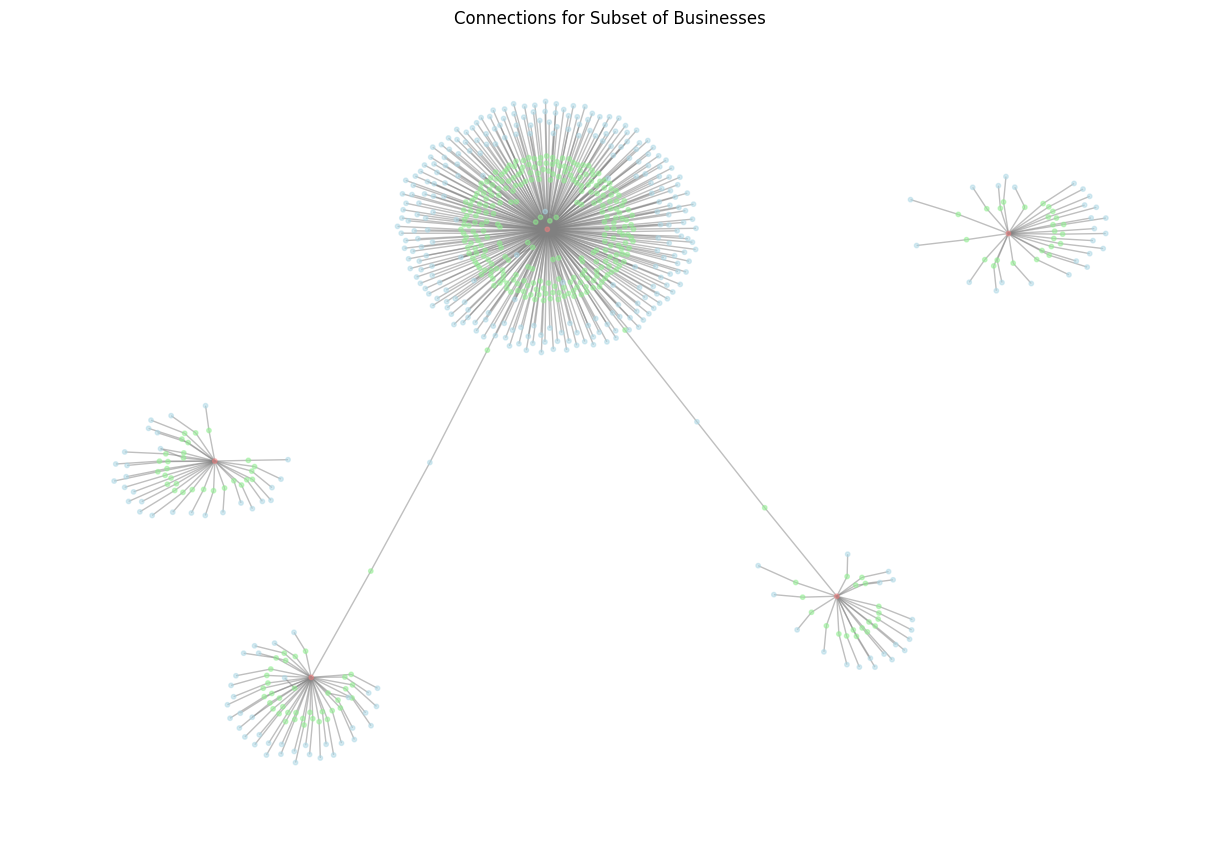

In [79]:
subset_size = 5
subset_businesses = business_data.head(subset_size)['business_id']

reviews_for_subset = review_data[review_data['business_id'].isin(subset_businesses)]

node_colors = {'user': 'lightblue', 'review': 'lightgreen', 'business': 'lightcoral'}

G = nx.Graph()

G.add_nodes_from(subset_businesses, type='business')
G.add_nodes_from(reviews_for_subset['review_id'], type='review')
G.add_nodes_from(reviews_for_subset['user_id'], type='user')

for _, row in reviews_for_subset.iterrows():
    G.add_edge(row['business_id'], row['review_id'])

for _, row in reviews_for_subset.iterrows():
    G.add_edge(row['user_id'], row['review_id'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)

node_color = [node_colors[G.nodes[n]['type']] for n in G.nodes]

nx.draw(G, pos, with_labels=False, node_size=10, node_color=node_color, edge_color='gray', alpha=0.5)
plt.title('Connections for Subset of Businesses')
plt.show()
